In [2]:
##################################################################################################
#IMPORT ALL NEEDED PACKAGES

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from keras import backend as K


In [3]:
##################################################################################################
#CHANGE ALL PARAMETERS HERE: DATA_DIR, IMG_SIZE, color, NAME

DATA_DIR = "C:/Users/zradlicz/Desktop/Jupyter/ME 4054/IMAGES/IMAGES_WITH_MASKS/all_images"
IMAGE_FOLDERS = os.listdir(DATA_DIR)

IMG_SIZE = 256
COLOR = 'clr'
if COLOR == 'gray':
    size = 1
else:
    size = 3
NAME = "segmentation_256_588_rgb_shuffled_acc_50valsplit.h5"

![FOLDER LAYOUT](Capture.PNG?raw=true)

In [4]:
##################################################################################################
# GET TRAINING DATA

training_data = []

def create_training_data(color):
    for img in IMAGE_FOLDERS:
            try:
                img_folder = os.path.join(DATA_DIR,img)
                mask_folder = os.path.join(DATA_DIR,img)
                img_folder = os.path.join(img_folder,'images')
                mask_folder = os.path.join(mask_folder,'masks')
                img_path = os.path.join(img_folder,img+'.jpg')
                mask_path = os.path.join(mask_folder,img+'.png')
                if color == 'gray':
                    img_array = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
                    mask_array = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
                else:
                    img_array = cv2.imread(img_path)
                    mask_array = cv2.imread(mask_path)
                #plt.imshow(img_array, cmap="gray")
                #plt.show
                new_img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                new_mask_array = cv2.resize(mask_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_img_array, new_mask_array])
                np.random.shuffle(training_data)
            except Exception as e:
                pass
        
create_training_data(COLOR)

In [5]:
##################################################################################################
#CONVERT TO NUMPY ARRAYS AND RESIZE FOR TRAINING

Xseg = []
yseg = []

for img,mask in training_data:
    Xseg.append(img)
    yseg.append(mask)
    

Xseg = np.array(Xseg).reshape(-1, IMG_SIZE, IMG_SIZE, size)
yseg = np.array(yseg).reshape(-1, IMG_SIZE, IMG_SIZE, size)

print("done with preprocessing")

done with preprocessing


256
(588, 256, 256, 3)
(588, 256, 256, 3)
Stored 'Xseg' (ndarray)
Stored 'yseg' (ndarray)


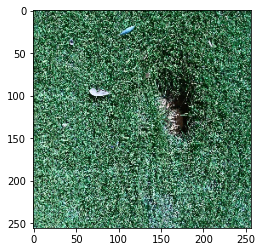

In [7]:
##################################################################################################
#SANITY CHECK

#Xseg = Xseg/255.0
#yseg = yseg/255.0
print(IMG_SIZE)
print(Xseg.shape)
print(yseg.shape)
%store Xseg
%store yseg
plt.imshow(Xseg[1])
K.clear_session()


In [172]:
#################################################################################################
#U-NET ARCHITECTURE

inputs = tf.keras.layers.Input((IMG_SIZE, IMG_SIZE, size))

c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu',kernel_initializer='he_normal',padding='same')(inputs)
c1 = tf.keras.layers.Dropout(.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu',kernel_initializer='he_normal',padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2 = tf.keras.layers.Dropout(.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu',kernel_initializer='he_normal',padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3 = tf.keras.layers.Dropout(.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4 = tf.keras.layers.Dropout(.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5 = tf.keras.layers.Dropout(.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu',kernel_initializer='he_normal',padding='same')(c5)

In [173]:
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6 = tf.keras.layers.Dropout(.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu',kernel_initializer='he_normal',padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7 = tf.keras.layers.Dropout(.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu',kernel_initializer='he_normal',padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides = (2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8 = tf.keras.layers.Dropout(.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu',kernel_initializer='he_normal',padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis = 3)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9 = tf.keras.layers.Dropout(.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu',kernel_initializer='he_normal',padding='same')(c9)

outputs = tf.keras.layers.Conv2D(size, (1,1), activation='sigmoid')(c9)

![FOLDER LAYOUT](u-net-architecture.png?raw=true)

In [174]:
##################################################################################################
#COMPILE THE MODEL

model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer='adam',loss='binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256, 256, 16) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 2320        dropout_9[0][0]                  
____________________________________________________________________________________________

In [175]:
##################################################################################################
#SET UP CALL BACKS FOR MONITORING PROGRESS

checkpointer = tf.keras.callbacks.ModelCheckpoint(NAME, monitor='val_loss', verbose=1, save_best_only=True)

callbacks = [
    checkpointer,
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_accuracy'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

In [186]:
##################################################################################################
#START TRAINING MODEL

results = model.fit(Xseg, yseg, batch_size = 32, epochs=25, validation_split=0.5, callbacks=callbacks)

Epoch 1/25
10/10 [==============================] - 141s 14s/step - loss: 0.0484 - accuracy: 0.3548 - val_loss: 0.0406 - val_accuracy: 0.4464

Epoch 00001: val_loss improved from 0.06076 to 0.04061, saving model to segmentation_256_588_rgb_shuffled_acc_50valsplit.h5
Epoch 2/25
10/10 [==============================] - 146s 15s/step - loss: 0.0436 - accuracy: 0.3128 - val_loss: 0.0367 - val_accuracy: 0.4780

Epoch 00002: val_loss improved from 0.04061 to 0.03672, saving model to segmentation_256_588_rgb_shuffled_acc_50valsplit.h5
Epoch 3/25
10/10 [==============================] - 145s 15s/step - loss: 0.0384 - accuracy: 0.3269 - val_loss: 0.0384 - val_accuracy: 0.3797

Epoch 00003: val_loss did not improve from 0.03672
Epoch 4/25
 4/10 [===========>..................] - ETA: 1:17 - loss: 0.0370 - accuracy: 0.2868

KeyboardInterrupt: 

In [24]:
###################################################################################################
# MONITOR LOSS AND ACCURACY
# NEED TO DELETE LOGS DIRECTORY FOR NEW MODEL

%reload_ext tensorboard
%tensorboard --logdir logs

#del /q %TMP%\.tensorboard-info\*
#taskkill /im tensorboard.exe /f




Reusing TensorBoard on port 6006 (pid 23068), started 2:27:54 ago. (Use '!kill 23068' to kill it.)

In [ ]:
##################################################################################################
# SEND TEXT TO TELL MYSELF TRAINING IS DONE


from twilio.rest import Client

# the following line needs your Twilio Account SID and Auth Token
client = Client("ACb8d1a6e2730223a941875c90b1d24e4a", "bb6b7145ef05895e9e0eaac0b17c6dc2")

# change the "from_" number to your Twilio number and the "to" number
# to the phone number you signed up for Twilio with, or upgrade your
# account to send SMS to any phone number
client.messages.create(to="+18473858545", 
                       from_="+13605161177", 
                       body='Training is Done')

In [9]:
predictions = model.predict(Xseg)

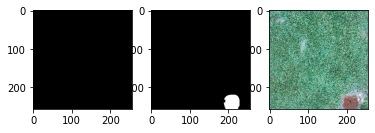

In [41]:
##################################################################################################
# PLOT RESULTS


val = 30


fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ax3.imshow(Xseg[val])
ax2.imshow(yseg[val])
ax1.imshow(predictions[val])